In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
import sys
sys.path.append('../')

from TSNE_code.TSNE_utils import TSNE
from sklearn.manifold import TSNE as sk_TSNE

# Comparison of Scikit-Learn and Custom t-SNE on MNIST faces

In [3]:
path_to_mnist_dataset = "digits.npz"

In [4]:
mnist_loader = np.load(path_to_mnist_dataset)
mnist_matrices = mnist_loader["x"] / 255
labels = mnist_loader["y"]
mnist_loader.close()

In [5]:
def plot_digit(ax, digit_vector, title=None, color="red"):
    digit = digit_vector.reshape(28, 28)
    ax.imshow(digit, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title, color="red" if color is None else color)

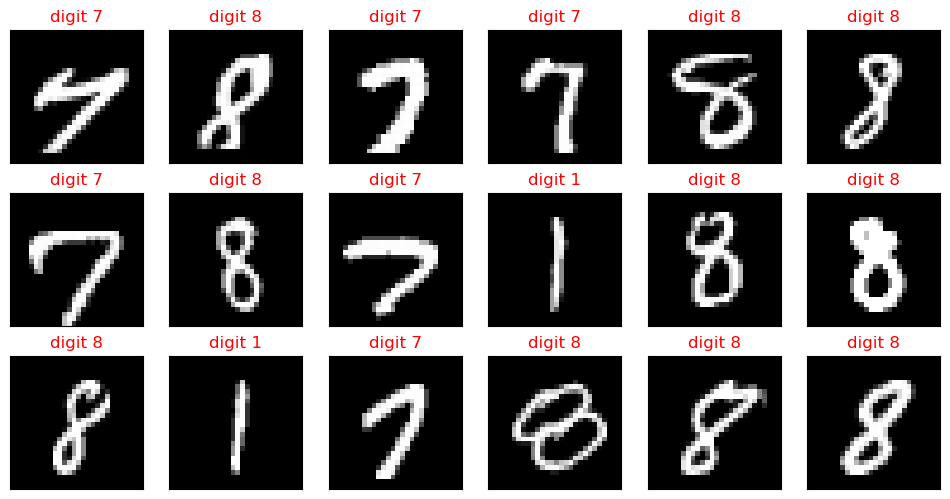

In [6]:
nrows, ncols = 3, 6
to_display = np.random.choice(range(len(mnist_matrices)), size=nrows*ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
cur_display = 0
for i in range(nrows):
    for j in range(ncols):
        digit_vector = mnist_matrices[to_display[cur_display]]
        plot_digit(axs[i][j], digit_vector, title=f"digit {labels[to_display[cur_display], 0]}")
        cur_display += 1

## t-SNE on MNIST data

In [7]:
def sklearn_tsne(X, n_components, perplexity):
    sk_tsne = sk_TSNE(n_components=n_components, learning_rate='auto', perplexity=perplexity, init='random')
    sk_embedding = sk_tsne.fit_transform(X)
    return sk_tsne, sk_embedding

In [8]:
def custom_tsne(X, n_components, perplexity, adaptive_lr, reference_kl_divergence=None):
    custom_tsne = TSNE(n_components=n_components, perplexity=perplexity, adaptive_learning_rate=adaptive_lr, patience=50, n_iter=1000)
    custom_embedding = custom_tsne.fit_transform(X, reference_kl_divergence=reference_kl_divergence,
                                                   title='Sk-learn KL divergence' if reference_kl_divergence is not None else '', verbose=0)
    return custom_tsne, custom_embedding

In [9]:
def compare_(X, n_components, perplexity):
    sk_tsne, sk_embedding = sklearn_tsne(X, n_components, perplexity)
    tsne_no_adpt_lr, custom_embedding_no_adpt_lr = custom_tsne(X, n_components, perplexity, adaptive_lr=False, reference_kl_divergence=sk_tsne.kl_divergence_)
    tsne_adpt_lr, custom_embedding_adpt_lr = custom_tsne(X, n_components, perplexity, adaptive_lr=True, reference_kl_divergence=sk_tsne.kl_divergence_)
    return sk_tsne, tsne_no_adpt_lr, tsne_adpt_lr, sk_embedding, custom_embedding_no_adpt_lr, custom_embedding_adpt_lr

In [10]:
def plot_scatter(X, ax, label='', title=''):
    ax.scatter(X[:, 0], X[:, 1], c=labels, label=label)
    ax.set_title(title)
    if label != '':
        ax.legend()
    
def plot_comparison(perplexity, sk_tsne, tsne_no_adpt_lr, tsne_adpt_lr, sk_embedding, custom_embedding_no_adpt_lr, custom_embedding_adpt_lr):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    plot_scatter(sk_embedding, axs[0], label=f'KL div = {round(sk_tsne.kl_divergence_, 4)}', title='Scikit-learn')
    plot_scatter(custom_embedding_no_adpt_lr, axs[1], label=f'KL div = {round(tsne_no_adpt_lr.kl_divergence[-1], 4)}', title='Custom t-SNE')
    plot_scatter(custom_embedding_adpt_lr, axs[2], label=f'KL div = {round(tsne_adpt_lr.kl_divergence[-1], 4)}', title='Custom t-SNE + adaptive lr')
    plt.suptitle(f'Perplexity: {perplexity}')
    plt.show()

## Run comparisons

In [11]:
def compare_and_plot(X, n_components, perplexity):
    sk_tsne, tsne_no_adpt_lr, tsne_adpt_lr, sk_embedding, custom_embedding_no_adpt_lr, custom_embedding_adpt_lr = compare_(X, n_components, perplexity)
    plot_comparison(perplexity, sk_tsne, tsne_no_adpt_lr, tsne_adpt_lr, sk_embedding, custom_embedding_no_adpt_lr, custom_embedding_adpt_lr)
    return sk_tsne, tsne_no_adpt_lr, tsne_adpt_lr

In [12]:
perplexities = range(5, 60, 5)

In [ ]:
sk_kl = []
no_adpt_lr_kl = []
adpt_lr_kl = []

for perplexity in perplexities:
    sk_tsne, tsne_no_adpt_lr, tsne_adpt_lr = compare_and_plot(mnist_matrices, 2, perplexity)
    sk_kl.append(sk_tsne.kl_divergence_)
    no_adpt_lr_kl.append(tsne_no_adpt_lr.kl_divergence[-1])
    adpt_lr_kl.append(tsne_adpt_lr.kl_divergence[-1])

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4))

axs[0].plot(perplexities, sk_kl)
axs[0].set_title('Scikit-Learn')

axs[1].plot(perplexities, no_adpt_lr_kl)
axs[1].set_title('Custom t-SNE')

axs[2].plot(perplexities, adpt_lr_kl)
axs[2].set_title('Custom t-SNE + adaptive lr')

plt.suptitle('Evolution of KL divergence wrt perplexity \n MNIST dataset');